
# Project: Medical Appointment No-Show Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this proyect, we'll be analyzing data from 110k medical appointments in Brazil. We'll be focusing in finding trends among the patients that show up for their appointments and how they differ from patients that don't show up. The dataset that we'll be investigating is originally available at [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments) and contains the following characteristics about the patients:

* PatientId - ID of the patient
* AppointmentID - ID of the appointment
* Gender - gender of the patient
* ScheduledDay - date the appointment was scheduled
* AppointmentDay - date of the appointment
* Age - age of the patient
* Neighbourhood - location of the hospital
* Scholarship - whether or not the patient is enrolled in Brazilian Welfare Program [Bolsa Família](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia)
* Hipertension - whether or not the patient suffers from Hipertension
* Diabetes - whether or not the patient suffers from Diabetes
* Alcoholism - whether or not the patient suffers from Alcoholism
* Handcap - whether or not the patient has a handicap
* SMS_received - whether or not the patient received an SMSs for the appointment
* No-show - whether or not the patient was a no-show for the appointment

We'll be insterested in looking at questions like:

* Are Males or Females more likely to miss their appointment?
* What day of the week are patients more likely to miss their appointment?
* Does the number of days that pass between the date of the appointment and the day it was scheduled influence in patients showing up or not?
* Does age factor in patients showing up or not to their appointment?
* Are patients from the Brazilian Welfare Program more likely to show to their appointments?
* What's the probability of patients suffering from a disease to miss the appointment?
* Does having a handicap increases the chance of No-Show?
* How does receiving an SMS affects the show or not show of appointments?

### Loading Libraries

We will start by importing the libraries and packages we are going to use, in this case NumPy, Pandas, Matplotlib and Seaborn. We are also going to include the matplotlib **inline** magic word to make sure our visualizations are plotted within our Jupyter notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline
sns.set_style('whitegrid')

<a id='wrangling'></a>
## Data Wrangling

In this section, we will start by loading our data an inspecting it. We will check for cleanliness; we then will proceed to trim and clean our dataset leaving just what we need for the analysis.
### Inspecting our data

We load our data from the csv into a dataframe and take a look at the structure of the data.

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


We inspect the number of samples and columns in the dataset.

In [3]:
df.shape

(110527, 14)

> + There are 14 features and 110,527 appointments.

We check if there are any features with missing values and their data types.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


> * There are no missing values.
* Dates in ScheduledDay and AppointmentDay are stored as strings.
* We should format the dates into a datetime format which will help with our analysis.

We look if there are duplicate rows in the dataset.

In [5]:
df.duplicated().sum()

0

> * There are no duplicate rows.

We get the number of unique values; we should get 110,527 unique values for the AppointmentID feature because each appointment should be unique.

In [6]:
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

> * We confirmed that the appointments are in fact unique.
* There are 104 unique age values, we might want to categorize age so it is easier to analyze.
* Gender and No-show have two unique values both, we should see what those are.

In [7]:
df.Gender.unique()

array(['F', 'M'], dtype=object)

> * Gender can be F (Female) or M (Male).

In [8]:
df['No-show'].unique()

array(['No', 'Yes'], dtype=object)

> * No-show has values of Yes or No.

Finally, we take a look at the summary statistics for the data.

In [9]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


> * Columns like PatiendId and AppointmentID won't really factor in our analysis so we will drop them when we are cleaning.
* Age has a min of -1, and since ages can't be negative we should drop rows containing negative values of age. We also see that most of the appointments are from people between the ages 18-55.
* Scholarship, Hipertension, Diabetes, Alcoholism and SMS_received can be true or false so they take values of 1 or 0.
* Handcap varies from 0 to 4 which represent the number of dissabilities the patient has; 0 if the patient has none.
* Around 10% of the patients benefit from Brazilian Welfare Program.
* Around 20% of the patiens suffer from Hipertension.
* Around 7% of the patients suffer from Diabetes.
* Around 3% of the patients suffer from Alcoholism.
* Around 2% of the patients are handicapped.
* Around 32% of the patients received an SMS.

### Cleaning our data

We drop the PatiendId and AppointmentID columns because they won't provide any useful information in our analysis. We won't be looking at the Neighbourhood distribution so we drop this one too.

In [10]:
df.drop(['PatientId', 'AppointmentID', 'Neighbourhood'], axis=1, inplace=True)

We confirm that the columns were in fact dropped.

In [11]:
df.head(1)

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,0,0,No


We replace characters we don't want in the column names and make them lowercase so it is easier to work.

In [12]:
df.rename(columns=lambda x: x.lower().replace("-", "_"), inplace=True)

We check out the new column labels.

In [13]:
df.columns

Index(['gender', 'scheduledday', 'appointmentday', 'age', 'scholarship',
       'hipertension', 'diabetes', 'alcoholism', 'handcap', 'sms_received',
       'no_show'],
      dtype='object')

We drop rows with ages that have negative values. We keep ages that are equal to zero as they probably represent newborns.

In [14]:
df = df[df['age'] >= 0]
df.shape

(110526, 11)

> * There was only one value below 0. Now we have 110,526 samples.

We change the format of the appointmentday and scheduledday columns to a a datetime format so we can extract more useful information later on.

In [15]:
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday'])

We confirm the type change.

In [16]:
df.dtypes

gender                    object
scheduledday      datetime64[ns]
appointmentday    datetime64[ns]
age                        int64
scholarship                int64
hipertension               int64
diabetes                   int64
alcoholism                 int64
handcap                    int64
sms_received               int64
no_show                   object
dtype: object

<a id='eda'></a>
## Exploratory Data Analysis

We now have our trimmed and cleaned data. In this section, we'll engineer features to use in our analysis and move on to exploration taking no_show as our dependent variable.

### Feature Engineering
We will classify each sample into a category depending on the age of the patient. For this, we will create a list for the values that we'll use to cut the data into groups and another list containing the names of those groups. We will then create a column in the dataframe to store our classification.

In [17]:
bin_edges = [0, 15, 25, 65, df.age.max()]
bin_edges

[0, 15, 25, 65, 115]

In [18]:
bin_names = ['child', 'youth', 'adult', 'senior']
bin_names

['child', 'youth', 'adult', 'senior']

In [19]:
df['age_category'] = pd.cut(df['age'], bin_edges, include_lowest=True, labels=bin_names)

We check that the column was created appropiately.

In [20]:
df.age_category.value_counts()

adult     58626
child     24468
youth     14131
senior    13301
Name: age_category, dtype: int64

We calculate and store the number of days that pass between the date of the appointment and the day it was scheduled. Here, since the day of the appointment doesn't have a time, we make the calculations with just the dates. Else we would get a values different to 0 on appointments that were scheduled on the same day they took place.

In [21]:
df['days_passed'] = (df['appointmentday'].dt.date - df['scheduledday'].dt.date).dt.days

We get the day of the week of the appointment and we create categories to later on sort easier.

In [22]:
df['day_of_week'] = df['appointmentday'].dt.weekday_name
df['day_of_week'] = pd.Categorical(df.day_of_week, \
                                        categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], \
                                        ordered=True)

We create a binary column for No-Show. So we are mainly interested in looking at no-shows, we will use 1 to indicate the No-Show. This will help us later on to calculate the propability of No-Show on certain features.

In [23]:
df['no_show_bin'] = pd.Series(np.where(df.no_show.values == 'Yes', 1, 0), df.index)

We check that the columns days_passed and day_of_week were created appropiately. Our data frame looks like this now:

In [24]:
df.head()

,gender,scheduledday,appointmentday,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,age_category,days_passed,day_of_week,no_show_bin
0,F,2016-04-29 18:38:08,2016-04-29,62,0,1,0,0,0,0,No,adult,0,Friday,0
1,M,2016-04-29 16:08:27,2016-04-29,56,0,0,0,0,0,0,No,adult,0,Friday,0
2,F,2016-04-29 16:19:04,2016-04-29,62,0,0,0,0,0,0,No,adult,0,Friday,0
3,F,2016-04-29 17:29:31,2016-04-29,8,0,0,0,0,0,0,No,child,0,Friday,0
4,F,2016-04-29 16:07:23,2016-04-29,56,0,1,1,0,0,0,No,adult,0,Friday,0


Since we are going to be looking at whether a patient showed or missed their appointment, we will use masks and grab these rows.

In [25]:
showed = df.no_show == 'No'
missed = df.no_show == 'Yes'

### General Information
Below we can see how the data is distributed depending on each variable.

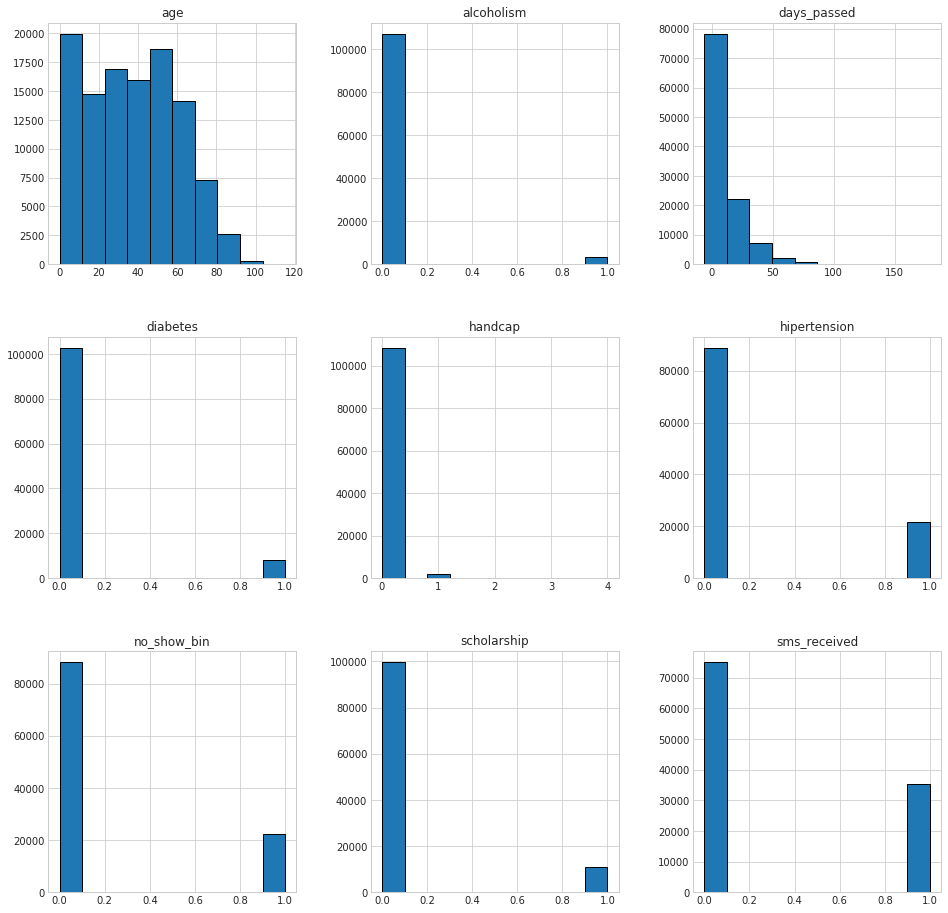

In [26]:
df.hist(figsize=(16,16), ec='black');

* The above agrees with what we saw in the summary statistics.
* Ages are skewed to the right with the majority between 20 and 60.
* The majority of patients don't suffer for alcoholism, diabetes, hipertension or a dissability.
* There's also a small percentage that benefits from Brazil's Welfare Program.
* The majority of the appointments were scheduled short before they took place.

### Proportion of Show vs No-show appointments
To plot the proportion of Show vs No-show appointments we need to get the number of appointments were patients showed up, the number of appointments were patients didn't show up and the total number of appointments.

In [27]:
counts = df.no_show.value_counts()
counts

No     88207
Yes    22319
Name: no_show, dtype: int64

In [28]:
total = df.count()['no_show']
total

110526

We get the proportions by dividing each group count by the total number of appointments.

In [29]:
proportions = counts/total
proportions

No     0.798066
Yes    0.201934
Name: no_show, dtype: float64

We then create a pie chart showing the proportion of Show vs No-show appointments.

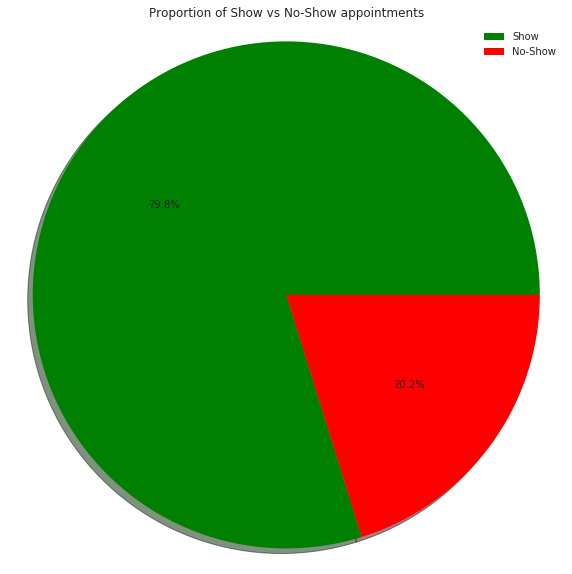

In [30]:
colors = ['green', 'red']
labels = ['Show', 'No-Show']
plt.pie(proportions, colors=colors, shadow=True, autopct='%1.1f%%')
plt.title('Proportion of Show vs No-Show appointments')
plt.axis('equal');
plt.legend(labels)
fig = plt.gcf()
fig.set_size_inches(10,10);

In the chart above we can see that the there's a higher proportion of appointments where the patient shows up.

### Are Males or Females more likely to miss their appointment?

We first want to compare the gender distribution and show vs no-show. We need to use proportions for this because the number of females is a lot higher than the number of males.

In [31]:
gender_counts = df.groupby('gender').no_show.value_counts()
gender_counts

gender  no_show
F       No         57245
        Yes        14594
M       No         30962
        Yes         7725
Name: no_show, dtype: int64

In [32]:
gender_totals = df.gender.value_counts()
gender_totals

F    71839
M    38687
Name: gender, dtype: int64

In [33]:
female_proportions = gender_counts['F'] / gender_totals['F']
female_proportions

no_show
No     0.796851
Yes    0.203149
Name: no_show, dtype: float64

In [34]:
male_proportions = gender_counts['M'] / gender_totals['M']
male_proportions

no_show
No     0.800321
Yes    0.199679
Name: no_show, dtype: float64

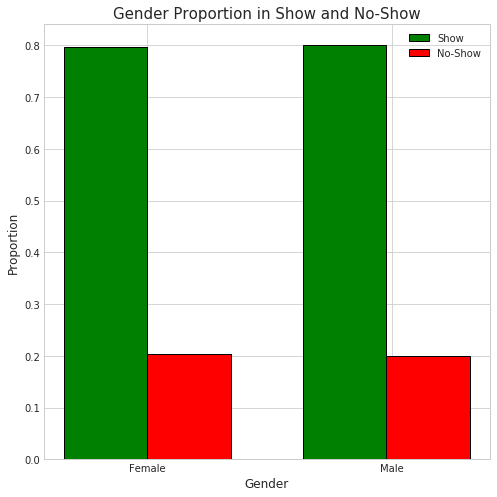

In [35]:
ind = np.array([0, 0.35])
width = 0.35
colors = ['g','r']
female_bars = plt.bar(ind, female_proportions, width, color=colors, alpha=1, ec='black')
male_bars = plt.bar(ind+1, male_proportions, width, color=colors, alpha=1, ec='black')
plt.title('Gender Proportion in Show and No-Show', fontsize=15)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
tick_locations = ind + np.array([0, .675]) + width / 2
tick_labels = ['Female', 'Male']
plt.xticks(tick_locations, tick_labels)
plt.legend((female_bars[0], female_bars[1]), ('Show', 'No-Show'))
plt.gcf().set_size_inches(8, 8);

As you can see above, the proportion of Show and No-Show are more or less the same for Males and Females. We can further take a look at how the genders are represented in the No-Show appointments. For this, we need to get the number of no-show appointments of each gender, the total number of no-show appointments and then calculate the proportions to plot the chart with.

In [36]:
no_show_gender_counts = df[missed].gender.value_counts()
no_show_gender_counts

F    14594
M     7725
Name: gender, dtype: int64

In [37]:
no_show_total = df[missed].gender.size
no_show_total

22319

In [38]:
no_show_gender_proportions = no_show_gender_counts / no_show_total
no_show_gender_proportions

F    0.653882
M    0.346118
Name: gender, dtype: float64

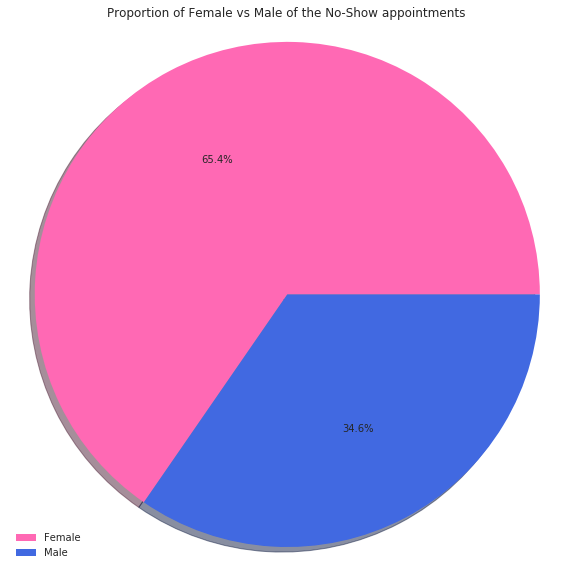

In [39]:
colors = ['hotpink', 'royalblue']
labels = ['Female', 'Male']
plt.pie(no_show_gender_proportions, colors=colors, shadow=True, autopct='%1.1f%%')
plt.title('Proportion of Female vs Male of the No-Show appointments')
plt.axis('equal');
plt.legend(labels)
fig = plt.gcf()
fig.set_size_inches(10,10);

In the chart above we can see that approximately 65% of the appointments are missed by females, but this is because there are further more appointments made by women than by men, so it is normal to see this. Given that the show and no-show percentages by genders are more or less the same, we don't see gender being a factor that could predict the likelihood of a patient missing an appointment.

### What day of the week are patients more likely to show to or miss their appointment?
We first want to see how the appointments are distributed during the week. We will get the proportions for each day and plot a pie chart.

In [40]:
weekday_proportions = df.day_of_week.value_counts()
weekday_proportions /= df.day_of_week.count()
weekday_proportions

Wednesday    0.234035
Tuesday      0.231982
Monday       0.205508
Friday       0.172077
Thursday     0.156045
Saturday     0.000353
Sunday       0.000000
Name: day_of_week, dtype: float64

There are no values

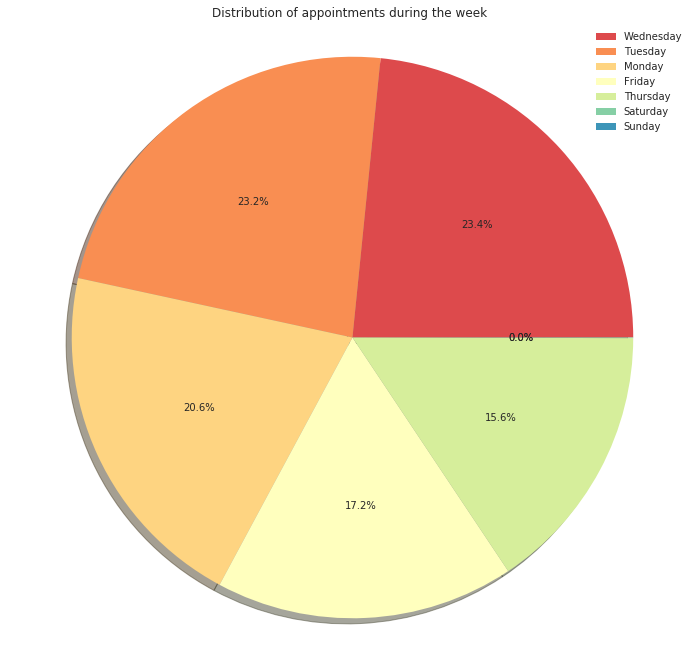

In [41]:
plt.pie(weekday_proportions, colors=sns.color_palette("Spectral", 7),shadow=True, autopct='%1.1f%%')
plt.title('Distribution of appointments during the week')
plt.axis('equal')
plt.legend(weekday_proportions.index)

plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10,10);

We can observe that most of the appointments are Scheduled for Tuesdays and Wednesdays. We will take a look at the daily distribution of shows and no-shows. We will first get the count per group for each day and then plot the charts.

In [42]:
no_show_weekdays_count = df[missed].day_of_week.value_counts().sort_index()
no_show_weekdays_count

Monday       4690
Tuesday      5152
Wednesday    5093
Thursday     3338
Friday       4037
Saturday        9
Sunday          0
Name: day_of_week, dtype: int64

In [43]:
show_weekdays_count = df[showed].day_of_week.value_counts().sort_index()
show_weekdays_count

Monday       18024
Tuesday      20488
Wednesday    20774
Thursday     13909
Friday       14982
Saturday        30
Sunday           0
Name: day_of_week, dtype: int64

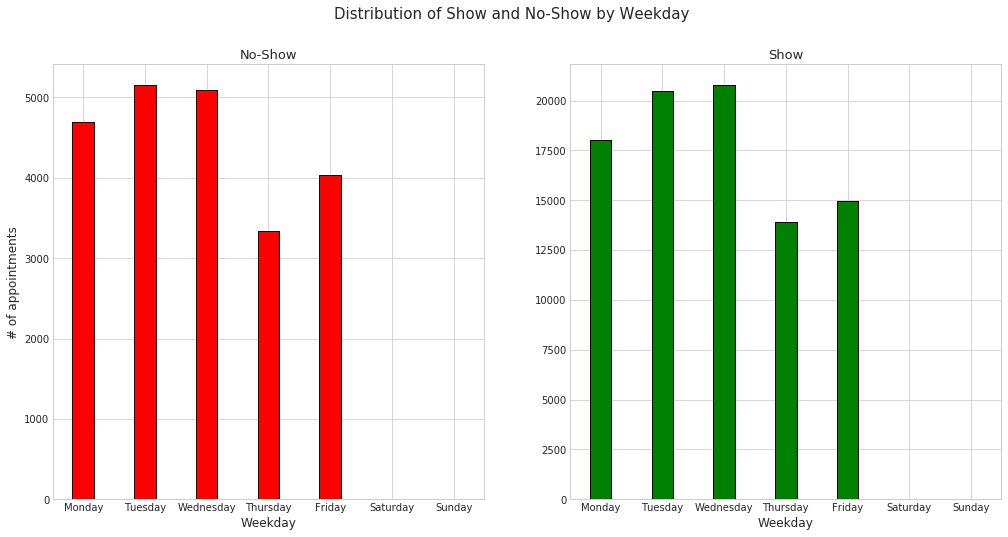

In [44]:
ind = np.arange(len(show_weekdays_count))
width = 0.35
tick_labels = show_weekdays_count.index

plt.subplot(1, 2, 1)
plt.bar(ind, no_show_weekdays_count, width, color='r', alpha=1, ec='black')
plt.title('No-Show', fontsize=13)
plt.ylabel('# of appointments', fontsize=12)
plt.xlabel('Weekday', fontsize=12)
plt.xticks(ind, tick_labels)

plt.subplot(1, 2, 2)
plt.bar(ind, show_weekdays_count, width, color='g', alpha=1, ec='black')
plt.title('Show', fontsize=13)
plt.xlabel('Weekday', fontsize=12)
plt.xticks(ind, tick_labels)

fig = plt.gcf()
fig.suptitle('Distribution of Show and No-Show by Weekday', fontsize=15)
fig.set_size_inches(17,8);

As we can see in the above graphs, most of the no-shows occur on Tuesdays while most of the shows occur on Wednesdays. The above graphics follow more or less the distribution we saw before in the pie chart. Since most of the appointments are scheduled for Tuesdays and Wednesdays we can't really make a fair comparison, so we are of better analyzing the No-Shows by day of the week.

In [45]:
week_prob = df.groupby('day_of_week').no_show_bin.mean()
week_prob

day_of_week
Monday       0.206481
Tuesday      0.200936
Wednesday    0.196892
Thursday     0.193541
Friday       0.212261
Saturday     0.230769
Sunday            NaN
Name: no_show_bin, dtype: float64

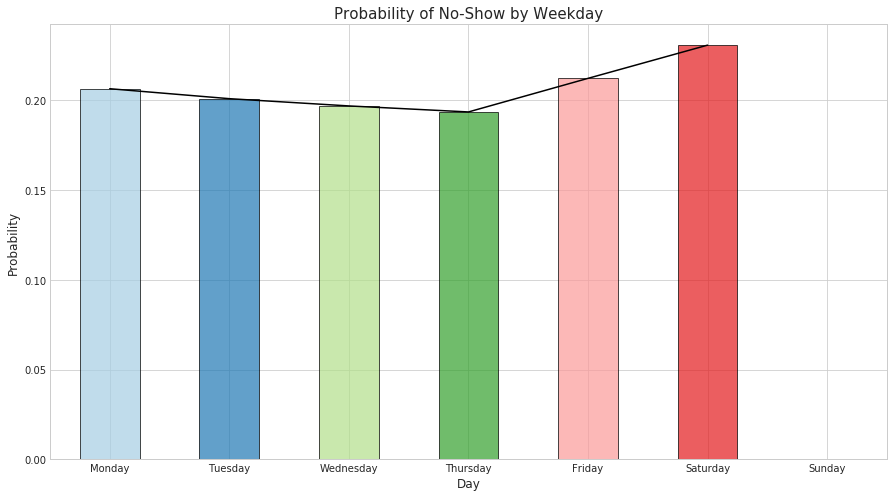

In [46]:
week_prob.plot(alpha=1, color='black')
week_prob.plot(kind='bar', color=[plt.cm.Paired(np.arange(len(week_prob)))], alpha=0.7, ec='black')
plt.title('Probability of No-Show by Weekday', fontsize=15)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xticks(rotation='horizontal')
plt.gcf().set_size_inches(15, 8)

We can see that the probability of missing appointments is lower during the middle of the week but increases at the end of the week. There's more chance for No-Show on Fridays and Saturdays and more chance of Show on Thursdays.

### Does the number of days that pass between the date of the appointment and the day it was scheduled influence in patients showing up or not?
We plot the frequency of the days passed between setting the appointment and the actual appointment for both Shows and No-Shows.

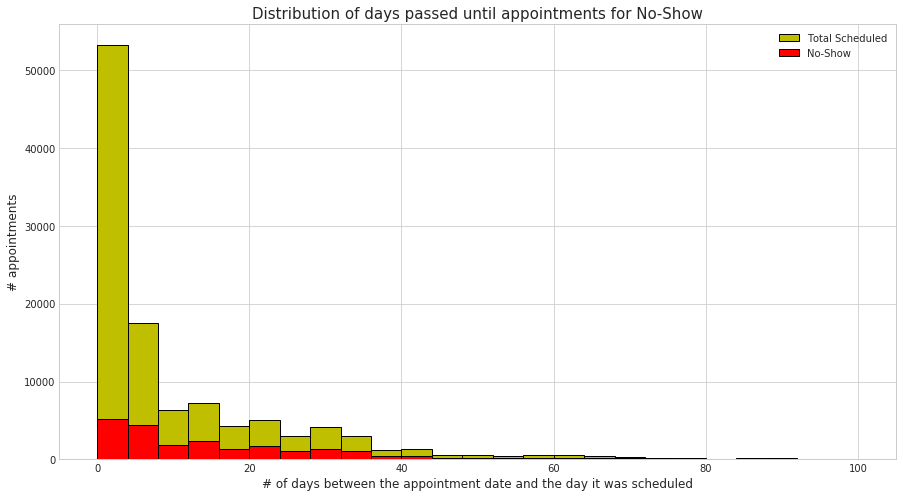

In [47]:
plt.hist(df.days_passed, bins=25, alpha=1, color='y', range=(0, 100), ec='black', label='Total Scheduled')
plt.hist(df[missed].days_passed, bins=25, alpha=1, color='r', range=(0, 100), ec='black', label='No-Show')
plt.title('Distribution of days passed until appointments for No-Show', fontsize=15)
plt.ylabel('# appointments', fontsize=12)
plt.xlabel('# of days between the appointment date and the day it was scheduled', fontsize=12)
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15,8);

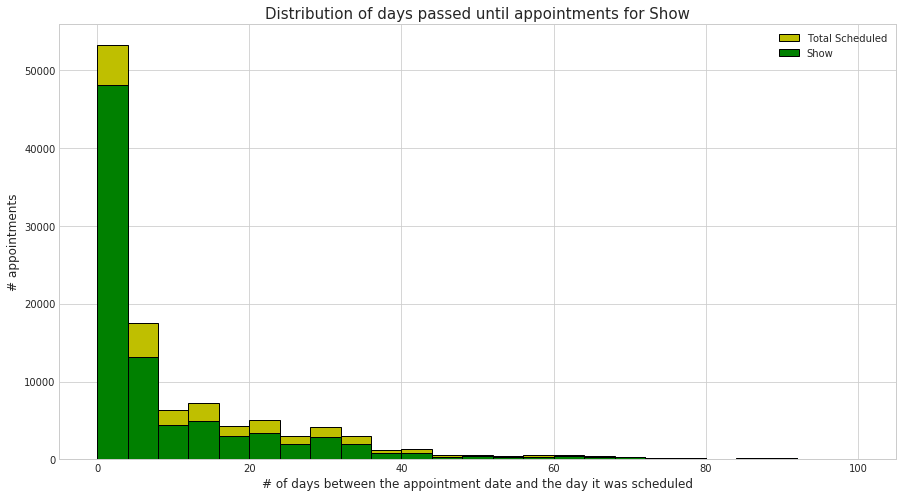

In [48]:
plt.hist(df.days_passed, bins=25, alpha=1, color='y', range=(0, 100), ec='black', label='Total Scheduled')
plt.hist(df[showed].days_passed, bins=25, alpha=1, color='g', range=(0, 100), ec='black', label='Show')
plt.title('Distribution of days passed until appointments for Show', fontsize=15)
plt.ylabel('# appointments', fontsize=12)
plt.xlabel('# of days between the appointment date and the day it was scheduled', fontsize=12)
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15,8);

Both graphs are skewed to the right. We can see that most No-Show appointments take place in the first 8 days after scheduling, which in retrospective can be considered normal as there are substantially more appointments in these day bins. Although there are significantly more appointments scheduled for the first 4 days, the number of missed appointments during the first 4 days are similar to the number of missed appointments from day 4 to day 8; this could indicate that there's a higher chance that people show to their appointments scheduled in the next 4 days. To corroborate this, lets see the probability of No-Show per days.

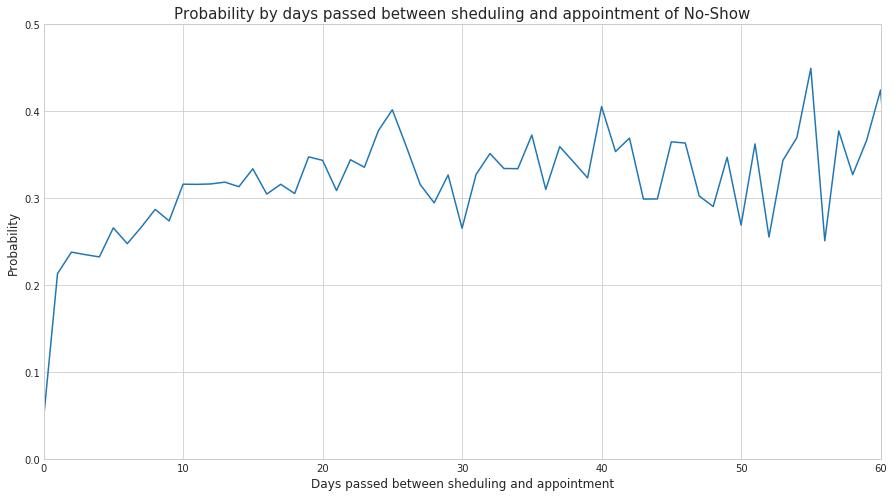

In [49]:
df.groupby('days_passed').no_show_bin.mean().plot()
plt.title('Probability by days passed between sheduling and appointment of No-Show', fontsize=15)
plt.xlabel('Days passed between sheduling and appointment', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xlim(0,60)
plt.ylim(0, 0.5)
plt.gcf().set_size_inches(15, 8)

There seems to be a higher chance of No-Show after the first 4 days.

### Does age factor in patients showing up or not to their appointment?

We'll first take a look at the mean of the patients that missed the appointment and the ones that showed up.

In [50]:
df.age[showed].mean()

37.790504154999034

In [51]:
df.age[missed].mean()

34.317666562121957

It looks that the patients who missed the appointment might be younger than the ones who attended, but we can see this more clearly looking at the frequency of ages using the age categories we created earlier on. In order to do this, we first need to filter our data, set the x coordinate location for each age group and width of each bar and then create the plot.

In [52]:
show_groups = df.groupby('no_show').age_category.value_counts()['No']
noshow_groups = df.groupby('no_show').age_category.value_counts()['Yes']

In [53]:
ind = np.arange(len(df.age_category.value_counts()))
width = 0.35

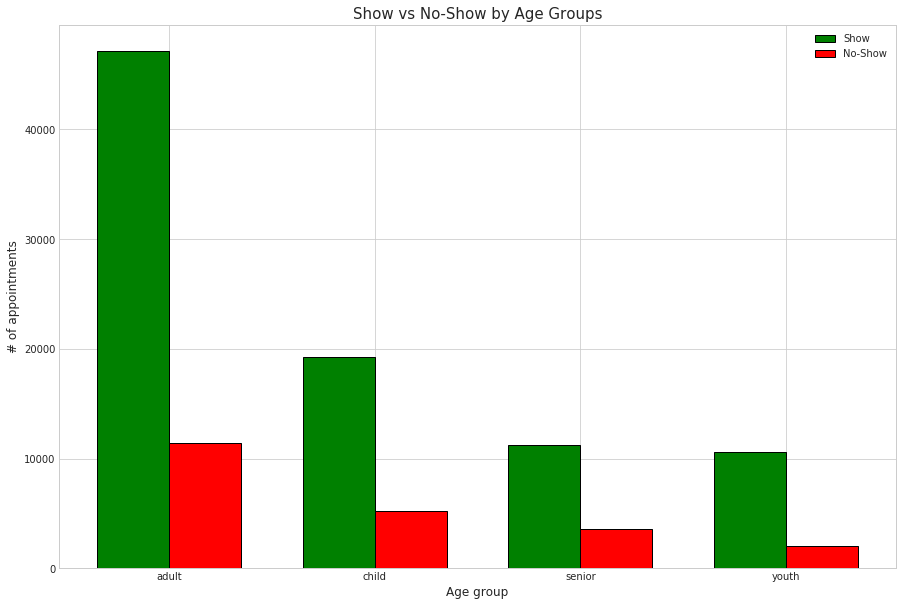

In [54]:
show_bars = plt.bar(ind, show_groups, width, color='g', alpha=1, label="Show", ec='black')
noshow_bars = plt.bar(ind+width, noshow_groups, width, color='r', alpha=1, label='No-Show', ec='black')
plt.title('Show vs No-Show by Age Groups', fontsize=15)
plt.xlabel('Age group', fontsize=12)
plt.ylabel('# of appointments', fontsize=12)
tick_locations = ind + width / 2
tick_labels = show_groups.index
plt.xticks(tick_locations, tick_labels)
plt.legend()
plt.gcf().set_size_inches(15,10);

The chart above doesn't show a clear tendency among age groups. Most of the patients that show up and miss the appointment are adults, with ages between 25 and 64. We can also see the distribution of ages using histograms below.

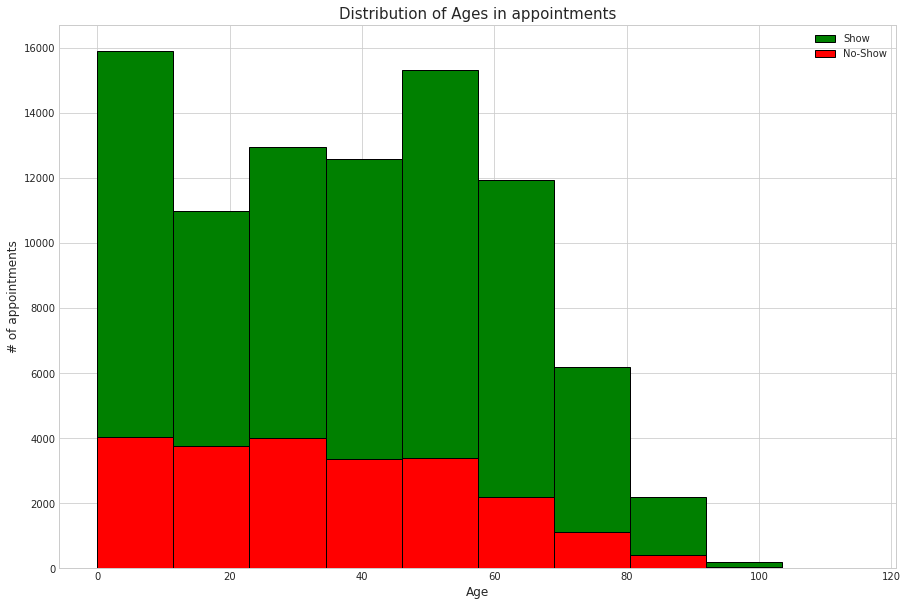

In [55]:
plt.hist(df.age[showed], alpha=1, color='g', label='Show', ec='black')
plt.hist(df.age[missed], alpha=1, color='r', label='No-Show', ec='black')
plt.title('Distribution of Ages in appointments', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('# of appointments', fontsize=12)
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15,10);

Both groups are skewed to the right. Lets look at the probability by age to miss an appointment, to see if there is a tendency.

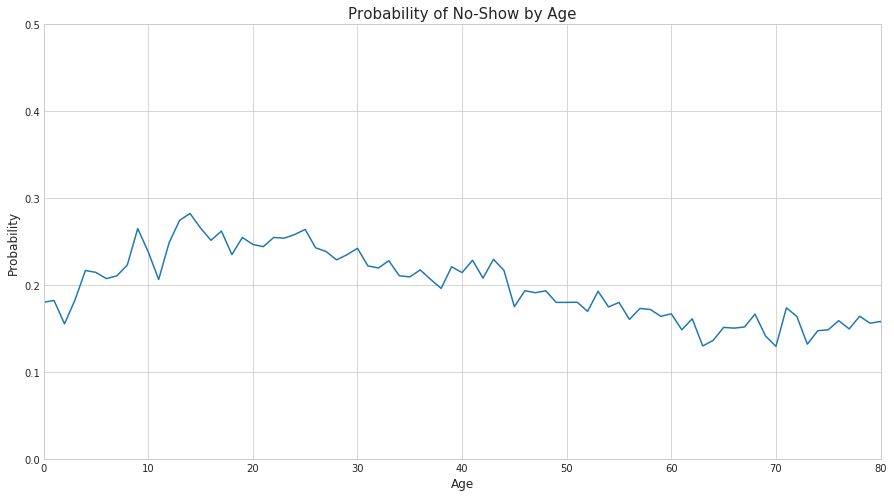

In [56]:
df.groupby('age').no_show_bin.mean().plot()
plt.title('Probability of No-Show by Age', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xlim(0,80)
plt.ylim(0, 0.5)
plt.gcf().set_size_inches(15, 8)

It seems that the chances of No-Show increase with children until around the age of 15, then the probability of No-Show reduces with increasing age; might be that older people are more concerned with their health.

### Are patients from the Brazilian Welfare Program more likely to show to their appointments?
We first pull the probability of no-show when being part of the Brazilian Welfare Program or not and then plot.

In [57]:
scholarship_prob = df.groupby('scholarship').no_show_bin.mean()
scholarship_prob

scholarship
0    0.198074
1    0.237363
Name: no_show_bin, dtype: float64

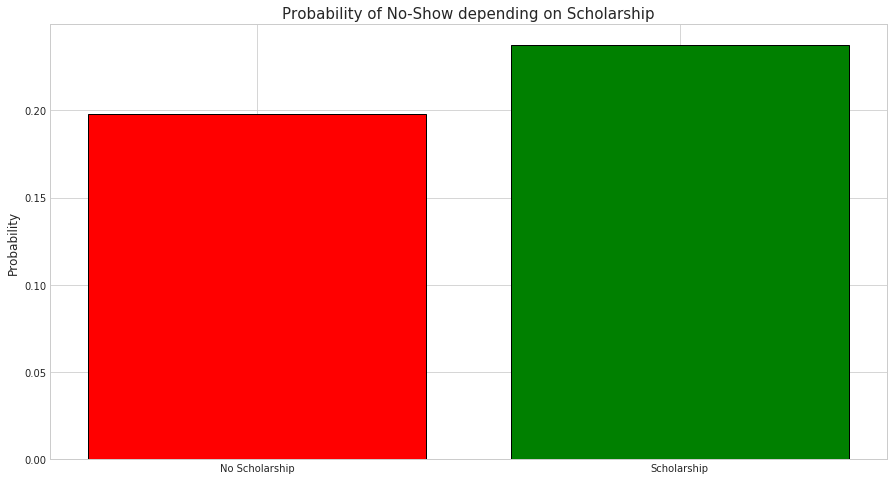

In [58]:
colors = ['r', 'g']
labels = ['No Scholarship', 'Scholarship']
plt.bar(scholarship_prob.index, scholarship_prob, color=colors, alpha=1, ec='black')
plt.title('Probability of No-Show depending on Scholarship', fontsize=15)
plt.ylabel('Probability', fontsize=12)
plt.xticks([0, 1], labels)
plt.gcf().set_size_inches(15, 8)

It seems that patients that are not part of the Welfare program are more likely to show up for their appointments while patients from the Welfare program have a higher probability of No-Show.

### What's the probability of patients suffering from a disease to miss the appointment?
We get the proportion of No-Show per disease.

In [59]:
hipertension_prob = df.groupby('hipertension').no_show_bin.mean()
diabetes_prob = df.groupby('diabetes').no_show_bin.mean()
alcoholism_prob = df.groupby('alcoholism').no_show_bin.mean()

We plot the probability of No-Show when having and not having the disease.

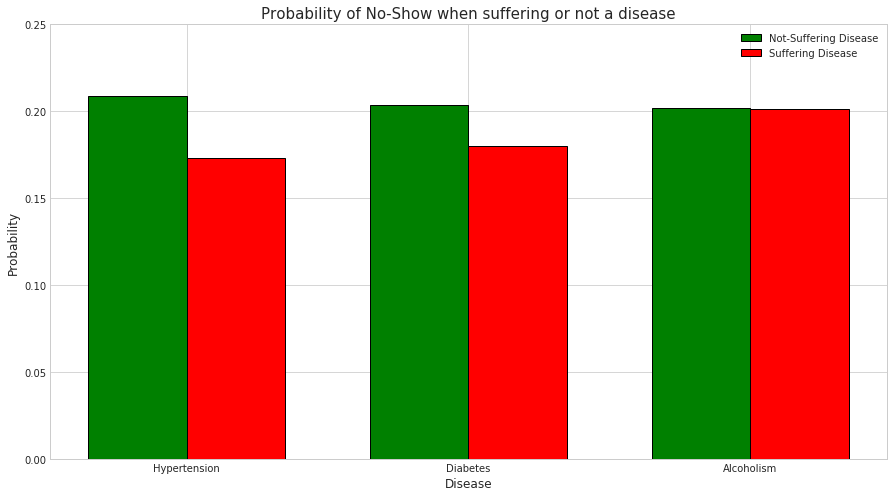

In [60]:
ind = np.array([0, 0.35])
width = 0.35
colors = ['g','r']
labels = ['Hypertension', 'Diabetes', 'Alcoholism']
locations = np.array([0, 1, 2]) + width / 2
hipertension_bars = plt.bar(ind, hipertension_prob, width, color=colors, alpha=1, ec='black')
diabetes_bars = plt.bar(ind+1, diabetes_prob, width, color=colors, alpha=1, ec='black')
alcoholism_bars = plt.bar(ind+2, alcoholism_prob, width, color=colors, alpha=1, ec='black')
plt.title('Probability of No-Show when suffering or not a disease', fontsize=15)
plt.xlabel('Disease', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.ylim(0, 0.25)
plt.xticks(locations, labels)
plt.legend((hipertension_bars[0], hipertension_bars[1]), ('Not-Suffering Disease', 'Suffering Disease'))
plt.gcf().set_size_inches(15,8)

We can see that patients with hypertension and diabetes have less chance of missing their appointment than patients without the disease. Alcoholism in the other hand, doesn't seem like a factor on No-Show.

### Does having a handicap increases the chance of No-Show?
To see how differents levels of handicap compares to not having one at all, we will plot the probability of missing the appointment of each group.

In [61]:
handicap_prob = df.groupby('handcap').no_show_bin.mean()
handicap_prob

handcap
0    0.202355
1    0.179236
2    0.202186
3    0.230769
4    0.333333
Name: no_show_bin, dtype: float64

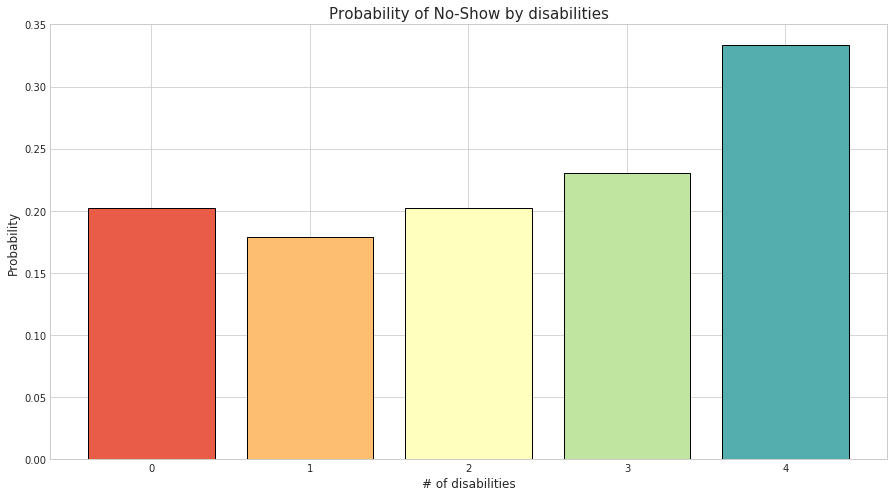

In [62]:
plt.bar(handicap_prob.index, handicap_prob, color=sns.color_palette("Spectral", 5), alpha=1, ec='black')
plt.title('Probability of No-Show by disabilities', fontsize=15)
plt.xlabel('# of disabilities', fontsize=12)
plt.ylabel('Probability', fontsize=12);
fig = plt.gcf()
fig.set_size_inches(15,8);

It definitely looks as the probability of No-Show increases when the number of handicaps increases.

### How does receiving an SMS affects the show or not show of appointments?
We will take a look at the probability of a patient showing and not showing when receiving or not an SMS. We first get the counts for each condition and then the probabilities of each.

In [63]:
sms_prob = df.groupby('sms_received').no_show.value_counts() / df.groupby('sms_received').sms_received.count()
sms_prob

sms_received  no_show
0             No         0.832965
              Yes        0.167035
1             No         0.724255
              Yes        0.275745
dtype: float64

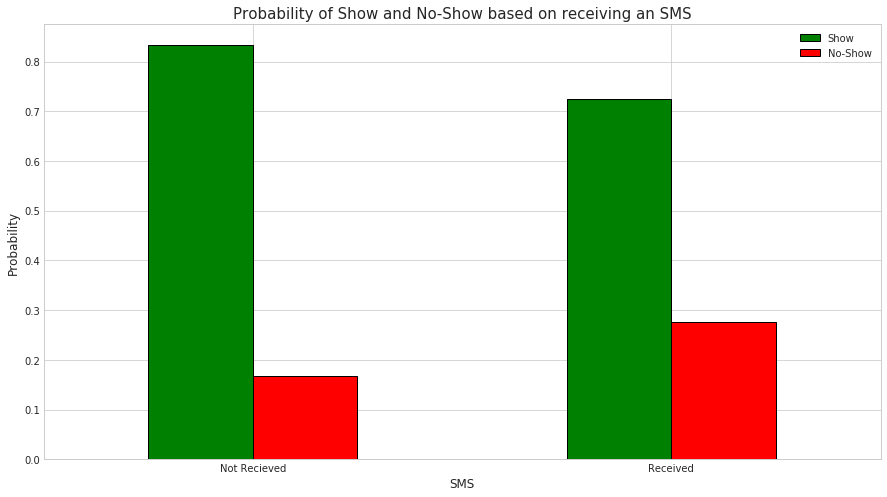

In [64]:
colors = ['g', 'r']
sms_bar = sms_prob.unstack().plot(kind='bar', color=colors, alpha=1, ec='black')
plt.xlabel('SMS', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Probability of Show and No-Show based on receiving an SMS', fontsize=15)
plt.xticks([0, 1], ['Not Recieved', 'Received'], rotation='horizontal')
plt.legend(('Show', 'No-Show'))
plt.gcf().set_size_inches(15, 8)

We can see that in the group of users that didn't receive an SMS there's a higher probability of Show. This probability of showing is lower when users get an SMS which is surprising because one would think that the SMS would serve as a reminder.

<a id='conclusions'></a>
## Conclusions
Given the type of analysis we did we are unable to infer causation of the No-Shows, we can only see the correlation between variables in the dataset and provide some parameters.

* Our sample was made of about 110K unique appointments, most of them scheduled by women which might hint that women are more concerned with their heath than men.
* The average age of patients in the dataset is 37.
* Around 10% of the patients benefit from Brazilian Welfare Program.
* Around 20% of the patiens suffer from Hipertension.
* Around 7% of the patients suffer from Diabetes.
* Around 3% of the patients suffer from Alcoholism.
* Around 2% of the patients are handicapped.
* Around 32% of the patients received an SMS.
* The majority of appointments took place in the first week after scheduled.
* The proportion of Show and No-Show are more or less the same for Males and Females, so both have the same chance to No-Show. The No-Show appointments are mostly by women, but this is because there are a lot more appointments made by women than by men. There doesn’t seem to be an association between gender and Show/No-Show.
* It seems that patients prefer to go to the doctor at the beginning of the week, most of the appointments are scheduled between Monday and Wednesday, being Tuesdays and Wednesdays of preference.
* Most appointments are missed on Tuesdays and most shows are on Wednesday, but this is because the majority of appointments are scheduled for those days. The actual probability of missing appointments is lower during the middle of the week but increases at the end of the week; there's more chance for No-Show on Fridays and Saturdays and more chance of Show on Thursdays.
* Most of the No-Show appointments take place in the first 8 days after scheduling, which in retrospective can be considered normal as there are substantially more appointments happening few days after they were scheduled. People prefer to schedule their appointments with a week or less in advance.
* There’s a higher chance for people to show to their appointments is these are scheduled in the following 4 days.
* Most patients are adults and the chances of No-Show increase with children until around the age of 15, then the probability of No-Show reduces with increasing age.
* Patients that are part of the Brazilian Welfare Program have a higher probability of No-Show.
* Patients with hypertension and diabetes have less chance of missing their appointments than patients without the disease. This would be something to expect since these are diseases that need to be controlled. Alcoholism in the other hand, doesn't seem like a factor on No-Show.
* The probability of No-Show increases when the number of handicaps increases, so there might be a strong association here.
* There’s a higher probability of Show when patients don’t receive an SMS.

## Resources used

* https://stackoverflow.com/questions/35193808/re-order-pandas-series-on-weekday
* https://stackoverflow.com/questions/25386870/pandas-plotting-with-multi-index
* https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/
* https://stackoverflow.com/questions/45967310/change-colours-of-pandas-bar-chart
* https://stackoverflow.com/questions/40901770/is-there-a-simple-way-to-change-a-column-of-yes-no-to-1-0-in-a-pandas-dataframe

In [65]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0